In [1]:
import numpy as np
from sklearn.decomposition import NMF
from scipy.stats.stats import pearsonr
%matplotlib inline
import sys
sys.path.append('..')
from cnmf import load_df_from_npz, get_highvar_genes 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from bhtsne import tsne 
import palettable 
import matplotlib.gridspec as gridspec

In [2]:
import scipy

def read_mtx(filename, dtype: str = "float32"):
    """\
    Read `.mtx` file.
    Parameters
    ----------
    filename
        The filename.
    dtype
        Numpy data type.
    """
    from scipy.io import mmread
    X = mmread(filename).astype(dtype)
    from scipy.sparse import csr_matrix
    X = csr_matrix(X)
    return X



In [3]:
import pandas as pd
Xobs = read_mtx('/Users/RachelJackson/Library/Mobile Documents/com~apple~CloudDocs/R-090321'+'/'+'LoGiudice_counts_file_lane1_4')
gene_metadata = pd.read_csv('/Users/RachelJackson/Library/Mobile Documents/com~apple~CloudDocs/R-090321'+'/'+'LoGiudice_gene_metadata_file_lane1_4', sep=',')
cell_metadata = pd.read_csv('/Users/RachelJackson/Library/Mobile Documents/com~apple~CloudDocs/R-090321'+'/'+'LoGiudice_cell_metadata_file_lane1_4', sep=',')

In [4]:
sizefactors = cell_metadata['sizeFactor'].values     # puts sizefactors into a numpy array
bool_genes_select = gene_metadata['HVG_sqrt'].values  # creates a boolean vector marking genes as HV or not
X_hvgenes = Xobs[bool_genes_select,:].T                 # keeps only HV genes and takes transpose
X_hvgenes = (X_hvgenes.T / sizefactors).T           # perform normalization on counts
TPM_hvgs= pd.DataFrame(X_hvgenes)

In [5]:
sizefactors = cell_metadata['sizeFactor'].values     # puts sizefactors into a numpy array
bool_genes_select = gene_metadata['HVG_FT'].values  # creates a boolean vector marking genes as HV or not
X_hvgenes = Xobs[bool_genes_select,:].T                 # keeps only HV genes and takes transpose
X_hvgenes = (X_hvgenes.T / sizefactors).T           # perform normalization on counts
TPM_hvgs_1= pd.DataFrame(X_hvgenes)

In [6]:
cell_metadata.head()

,Unnamed: 0,lane,barcode,sum,detected,percent_top_50,percent_top_100,percent_top_200,percent_top_500,subsets_Mito_sum,...,cc_G2M_score,cc_S_score,cc_Phase,Photoreceptor_Precursors,Neurogenic,Amacrine_cells,Late_Progenitor,Early_Progenitor,RGC,other
0,AAACCTGAGATGTCGG,Lane1,AAACCTGAGATGTCGG,3222,1414,26.784606,39.137182,52.389820,71.632526,112,...,0.109,0.234,G1,8.481315e-03,2.809163e-02,1.627095e-06,5.139025e-04,9.309512e-01,2.147972e-03,2.981234e-02
1,AAACCTGCAATCCAAC,Lane1,AAACCTGCAATCCAAC,2551,1281,24.186593,35.711486,49.235594,69.384555,97,...,0.111,0.005,G1,2.087432e-02,1.393036e-02,1.029493e-07,2.942941e-04,8.899110e-01,6.541481e-03,6.844849e-02
2,AAACCTGGTTCCTCCA,Lane1,AAACCTGGTTCCTCCA,10358,2996,32.554547,41.320718,51.255069,65.794555,287,...,0.007,0.396,G1,1.653679e-11,4.201438e-12,5.958423e-19,1.004168e-13,1.238913e-14,1.000000e+00,1.955208e-10
3,AAACCTGTCCAATGGT,Lane1,AAACCTGTCCAATGGT,2736,1410,26.461988,36.074561,48.062865,66.739766,95,...,0.000,0.411,G1,6.730015e-02,2.379681e-01,6.772000e-03,9.341630e-04,7.809395e-03,4.533106e-01,2.259056e-01
4,AAACGGGAGGCAATTA,Lane1,AAACGGGAGGCAATTA,9226,2755,25.579883,37.762844,50.205940,65.716454,225,...,1.000,0.009,G2M,1.910176e-19,8.872248e-19,3.917819e-31,9.624606e-21,1.000000e+00,6.326453e-22,2.869543e-18


Run cross-validation for scaled square-root transformed data, using Kullback-Leibler divergence cost function:

In [7]:
sqrt_TPM_hvgs=np.sqrt(TPM_hvgs)
sqrt_TPM_hvgs = sqrt_TPM_hvgs/ sqrt_TPM_hvgs.std(axis=0) #scaling

In [13]:
from scipy import special
p=-1
seeds=[10,123,1001,101010,234567]
training_costs6=np.zeros((30,15,5))
test_costs6=np.zeros((30,15,5))
for i in seeds:
    np.random.seed(i)
    p+=1
    nrows = 2467
    ncols = 2000
    pmask = 0.3 # mask 30% of entries
    M=np.random.choice([0, 1], size=(nrows,ncols), p=[pmask, 1-pmask])
    Z_init=np.multiply(M,sqrt_TPM_hvgs)
    ntest6=[]
    ntrain6=[]
    for n in range(15):
        Z=Z_init #Z_init is the same for all n_components
        for l in range(30):
            print(l)
            model= NMF(n_components=n+1, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu')
            U = model.fit_transform(Z)
            V = model.components_
            UV=np.matmul(U,V)
            Z=Z_init+np.multiply((1-M),UV)
            training_cost=((special.kl_div(Z,UV+1e-10)).sum(axis=0)).sum(axis=0) #KLD
            training_costs6[l,n,p]=training_cost
            test_cost=((special.kl_div(np.multiply((1-M),sqrt_TPM_hvgs), np.multiply((1-M),UV)+1e-10)).sum(axis=0)).sum(axis=0)
            test_costs6[l,n,p]=test_cost
    ntest6.append((1-M).sum())
    ntrain6.append((M).sum()) 
    print(ntest6)
    print(ntrain6)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1481176]
[3452824]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1481880]
[3452120]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1481438]
[3452562]


Plot cross-validation results:

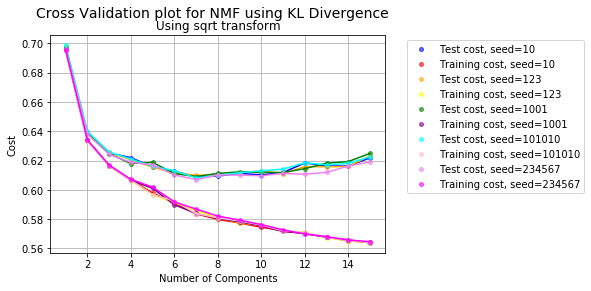

In [21]:
j=list(range(1,16))
plt.plot(j, test_costs6[29,:,0]/1481176, "o",markersize=4, alpha=0.6, color='blue', label="Test cost, seed=10")
plt.plot(j, test_costs6[29,:,0]/1481176, color="blue")
plt.plot(j, training_costs6[29,:,0]/3452824, "o",markersize=4, alpha=0.6, color="red", label="Training cost, seed=10")
plt.plot(j, training_costs6[29,:,0]/3452824, color="red")
plt.plot(j, test_costs6[29,:,1]/1479523, "o",markersize=4, alpha=0.6, color='orange', label="Test cost, seed=123")
plt.plot(j, test_costs6[29,:,1]/1479523, color="orange")
plt.plot(j, training_costs6[29,:,1]/3454477, "o",markersize=4, alpha=0.6, color="yellow", label="Training cost, seed=123")
plt.plot(j, training_costs6[29,:,1]/3454477, color="yellow")
plt.plot(j, test_costs6[29,:,2]/1481880, "o",markersize=4, alpha=0.6, color='green', label="Test cost, seed=1001")
plt.plot(j, test_costs6[29,:,2]/1481880, color="green")
plt.plot(j, training_costs6[29,:,2]/3452120, "o",markersize=4, alpha=0.6, color="purple", label="Training cost, seed=1001")
plt.plot(j, training_costs6[29,:,2]/3452120, color="purple")
plt.plot(j, test_costs6[29,:,3]/1480683, "o",markersize=4, alpha=0.6, color='cyan', label="Test cost, seed=101010")
plt.plot(j, test_costs6[29,:,3]/1480683, color="cyan")
plt.plot(j, training_costs6[29,:,3]/3453317, "o",markersize=4, alpha=0.6, color="pink", label="Training cost, seed=101010")
plt.plot(j, training_costs6[29,:,3]/3453317, color="pink")
plt.plot(j, test_costs6[29,:,4]/1481438, "o",markersize=4, alpha=0.6, color='violet', label="Test cost, seed=234567")
plt.plot(j, test_costs6[29,:,4]/1481438, color="violet")
plt.plot(j, training_costs6[29,:,4]/3452562, "o",markersize=4, alpha=0.6, color="magenta", label="Training cost, seed=234567")
plt.plot(j, training_costs6[29,:,4]/3452562, color="magenta")
plt.xlabel("Number of Components")
plt.ylabel("Cost")
plt.suptitle("Cross Validation plot for NMF using KL Divergence", fontsize=14)
plt.title("Using sqrt transform")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Run cross-validation for scaled Freeman-Tukey transformed data, using Kullback-Leibler divergence cost function:

In [16]:
stabilize_TPM_hvgs=np.sqrt(TPM_hvgs_1)+np.sqrt(TPM_hvgs_1+1)
stabilize_TPM_hvgs = stabilize_TPM_hvgs/ stabilize_TPM_hvgs.std(axis=0) #scaling

In [17]:
from scipy import special
p=-1
seeds=[10,123,1001,101010,234567]
training_costs5=np.zeros((30,15,5))
test_costs5=np.zeros((30,15,5))
for i in seeds:
    np.random.seed(i)
    p+=1
    nrows = 2467
    ncols = 2000
    pmask = 0.3 # mask 30% of entries
    M=np.random.choice([0, 1], size=(nrows,ncols), p=[pmask, 1-pmask])
    Z_init=np.multiply(M,stabilize_TPM_hvgs)
    ntest5=[]
    ntrain5=[]
    for n in range(15):
        Z=Z_init #Z_init is the same for all n_components
        for l in range(30):
            print(l)
            model= NMF(n_components=n+2, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu')
            U = model.fit_transform(Z)
            V = model.components_
            UV=np.matmul(U,V)
            Z=Z_init+np.multiply((1-M),UV)
            training_cost=((special.kl_div(Z,UV+1e-10)).sum(axis=0)).sum(axis=0) #KLD
            training_costs5[l,n,p]=training_cost
            test_cost=((special.kl_div(np.multiply((1-M),stabilize_TPM_hvgs), np.multiply((1-M),UV)+1e-10)).sum(axis=0)).sum(axis=0)
            test_costs5[l,n,p]=test_cost
    ntest5.append((1-M).sum())
    ntrain5.append((M).sum()) 
    print(ntest5)
    print(ntrain5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


[1481176]
[3452824]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


[1479523]
[3454477]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


[1481880]
[3452120]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0
1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


[1480683]
[3453317]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


11


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


17


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


18


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


19


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


21


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


22


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


23


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


24


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


25


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


26


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


27


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


28


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


[1481438]
[3452562]


Plot cross-validation results:

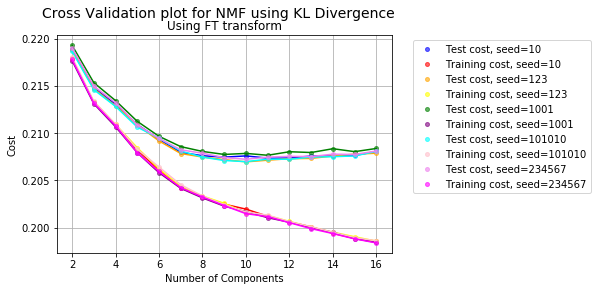

In [20]:
j=list(range(2,17))
plt.plot(j, test_costs5[29,:,0]/1481176, "o",markersize=4, alpha=0.6, color='blue', label="Test cost, seed=10")
plt.plot(j, test_costs5[29,:,0]/1481176, color="blue")
plt.plot(j, training_costs5[29,:,0]/3452824, "o",markersize=4, alpha=0.6, color="red", label="Training cost, seed=10")
plt.plot(j, training_costs5[29,:,0]/3452824, color="red")
plt.plot(j, test_costs5[29,:,1]/1479523, "o",markersize=4, alpha=0.6, color='orange', label="Test cost, seed=123")
plt.plot(j, test_costs5[29,:,1]/1479523, color="orange")
plt.plot(j, training_costs5[29,:,1]/3454477, "o",markersize=4, alpha=0.6, color="yellow", label="Training cost, seed=123")
plt.plot(j, training_costs5[29,:,1]/3454477, color="yellow")
plt.plot(j, test_costs5[29,:,2]/1481880, "o",markersize=4, alpha=0.6, color='green', label="Test cost, seed=1001")
plt.plot(j, test_costs5[29,:,2]/1481880, color="green")
plt.plot(j, training_costs5[29,:,2]/3452120, "o",markersize=4, alpha=0.6, color="purple", label="Training cost, seed=1001")
plt.plot(j, training_costs5[29,:,2]/3452120, color="purple")
plt.plot(j, test_costs5[29,:,3]/1480683, "o",markersize=4, alpha=0.6, color='cyan', label="Test cost, seed=101010")
plt.plot(j, test_costs5[29,:,3]/1480683, color="cyan")
plt.plot(j, training_costs5[29,:,3]/3453317, "o",markersize=4, alpha=0.6, color="pink", label="Training cost, seed=101010")
plt.plot(j, training_costs5[29,:,3]/3453317, color="pink")
plt.plot(j, test_costs5[29,:,4]/1481438, "o",markersize=4, alpha=0.6, color='violet', label="Test cost, seed=234567")
plt.plot(j, test_costs5[29,:,4]/1481438, color="violet")
plt.plot(j, training_costs5[29,:,4]/3452562, "o",markersize=4, alpha=0.6, color="magenta", label="Training cost, seed=234567")
plt.plot(j, training_costs5[29,:,4]/3452562, color="magenta")
plt.xlabel("Number of Components")
plt.ylabel("Cost")
plt.suptitle("Cross Validation plot for NMF using KL Divergence", fontsize=14)
plt.title("Using FT transform")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()